In [11]:
from scipy import optimize
import pandas as pd
import arviz as az
import numpy as np
import pymc as pm


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
df = pd.read_csv("MRI_measurements.csv", index_col=0)

df.head()

,b,t,signal
0,0.00,0.0,1.020676
1,0.00,13.0,0.774906
2,0.00,93.0,0.229304
3,0.00,143.0,0.184968
4,0.15,0.0,0.850762


1. Deterministic approach

In [3]:
bvals = np.sort(df["b"].unique())
tvals = np.sort(df["t"].unique())

print("bvals:", bvals)
print("tvals:", tvals)

# 4x4 matrix: rows=b, cols=t
signal_mat = df.pivot(index="b", columns="t", values="signal").loc[bvals, tvals].values

signal_mat


bvals: [0.   0.15 1.   1.5 ]
tvals: [  0.  13.  93. 143.]


array([[1.02067603, 0.7749065 , 0.22930429, 0.18496767],
       [0.85076191, 0.68850139, 0.20197533, 0.06617956],
       [0.4556537 , 0.34244007, 0.09632894, 0.0221935 ],
       [0.41274865, 0.19457713, 0.10713999, 0.02944364]])

In [6]:
def three_compartment_fit(M, D_ep, D_st, T2_ep, V_ep, V_st):

    D_lu = 2.9       
    T2_st = 80       
    T2_lu = 750      
    b, t = M
    S_ep = V_ep * np.exp(-b * D_ep) * np.exp(-t / T2_ep)
    S_st = V_st * np.exp(-b * D_st) * np.exp(-t / T2_st)
    S_lu = (1.0 - V_ep - V_st) * np.exp(-b * D_lu) * np.exp(-t / T2_lu)

    return S_ep + S_st + S_lu


In [7]:
def hybrid_fit(signals, bvals=[0, 0.15, 1, 1.5], t=[0, 13, 93, 143]):
    voxel = signals
    X, Y = np.meshgrid(t, bvals)
    xdata = np.vstack((Y.ravel(), X.ravel()))
    ydata = voxel.ravel()
    v = np.zeros((3))
    try:
        fitdata_, _ = optimize.curve_fit(
            three_compartment_fit,
            xdata,
            ydata,
            p0=[0.55, 1.3, 50, 0.3, 0.4],
            check_finite=True,
            bounds=([0.3, 0.7, 20, 0, 0],
                    [0.7, 1.7, 70, 1, 1]),
            method="trf",
            maxfev=5000,
        )
    except RuntimeError:
        fitdata_ = [0.55, 1.3, 50, 0.3, 0.4]

    coeffs = fitdata_
    D_ep, D_st, T2_ep, V_ep, V_st = fitdata_
    V_lu = 1.0 - V_ep - V_st

    return D_ep, D_st, T2_ep, V_ep, V_st, V_lu


In [8]:
D_ep, D_st, T2_ep, V_ep, V_st, V_lu = hybrid_fit(
    signal_mat,
    bvals=bvals.tolist(),
    t=tvals.tolist()
)

print(f"D_ep (y1, epithelium diffusivity): {D_ep:.4f}")
print(f"D_st (y2, stroma diffusivity):    {D_st:.4f}")
print(f"T2_ep (z1, epithelium T2):         {T2_ep:.4f}")
print(f"V_ep (x1, epithelium volume):      {V_ep:.4f}")
print(f"V_st (x2, stroma volume):          {V_st:.4f}")
print(f"V_lu (x3, lumen volume):           {V_lu:.4f}")
print(f"Sum of volumes:                    {V_ep + V_st + V_lu:.4f}")


D_ep (y1, epithelium diffusivity): 0.3000
D_st (y2, stroma diffusivity):    0.9778
T2_ep (z1, epithelium T2):         24.0455
V_ep (x1, epithelium volume):      0.3340
V_st (x2, stroma volume):          0.6116
V_lu (x3, lumen volume):           0.0544
Sum of volumes:                    1.0000


In [9]:
X, Y = np.meshgrid(tvals, bvals)
xdata = np.vstack((Y.ravel(), X.ravel()))

fitted = three_compartment_fit(
    xdata,
    D_ep, D_st, T2_ep, V_ep, V_st
).reshape(signal_mat.shape)

residuals = signal_mat - fitted
mse = np.mean(residuals**2)

print("MSE of fit:", mse)
residuals


MSE of fit: 0.0010460337865901314


array([[ 0.02067603,  0.00705683, -0.01697803,  0.03677918],
       [-0.03192317,  0.0189854 , -0.00096357, -0.05215263],
       [-0.02482862, -0.0001545 ,  0.01656969, -0.01943433],
       [ 0.05798482, -0.05007454,  0.05794397,  0.00468932]])

2. Bayesian approach

In [12]:
b = df["b"].values.astype(float)       
t = df["t"].values.astype(float)       
y_obs_data = df["signal"].values.astype(float)

b, t, y_obs_data[:5]

(array([0.  , 0.  , 0.  , 0.  , 0.15, 0.15, 0.15, 0.15, 1.  , 1.  , 1.  ,
        1.  , 1.5 , 1.5 , 1.5 , 1.5 ]),
 array([  0.,  13.,  93., 143.,   0.,  13.,  93., 143.,   0.,  13.,  93.,
        143.,   0.,  13.,  93., 143.]),
 array([1.02067603, 0.7749065 , 0.22930429, 0.18496767, 0.85076191]))

In [13]:
with pm.Model() as mri_model:
    v = pm.Dirichlet("v", a=np.array([1.0, 1.0, 1.0]))
    v_ep = v[0]
    v_st = v[1]
    v_lu = v[2]

    D_ep = pm.Uniform("D_ep", lower=0.3, upper=0.7)   # epithelium diffusivity
    D_st = pm.Uniform("D_st", lower=0.7, upper=1.7)   # stroma diffusivity
    T2_ep = pm.Uniform("T2_ep", lower=20.0, upper=70.0)  # epithelium T2

    D_lu = 2.9
    T2_st = 80.0
    T2_lu = 750.0


    S_ep = v_ep * pm.math.exp(-b * D_ep) * pm.math.exp(-t / T2_ep)
    S_st = v_st * pm.math.exp(-b * D_st) * pm.math.exp(-t / T2_st)
    S_lu = v_lu * pm.math.exp(-b * D_lu) * pm.math.exp(-t / T2_lu)
    S = S_ep + S_st + S_lu

    sigma = pm.HalfNormal("sigma", sigma=0.3)

    y_like = pm.Rice("y_obs", nu=S, sigma=sigma, observed=y_obs_data)


In [14]:
with mri_model:
    trace = pm.sample(
        draws=2000,       
        tune=2000,        
        chains=4,
        target_accept=0.9, 
        random_seed=42
    )

Initializing NUTS using jitter+adapt_diag...
c:\Users\jjjia\Desktop\ADSP-30124\ads\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:887: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
c:\Users\jjjia\Desktop\ADSP-30124\ads\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:887: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, D_ep, D_st, T2_ep, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 525 seconds.


In [15]:
summary = az.summary(
    trace,
    var_names=["v", "D_ep", "D_st", "T2_ep", "sigma"],
    round_to=4
)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v[0],0.6021,0.1407,0.3586,0.8607,0.0030,0.0015,2229.4040,3122.8510,1.0019
v[1],0.2985,0.1683,0.0004,0.5647,0.0035,0.0017,2119.0861,2096.0175,1.0021
v[2],0.0994,0.0487,0.0025,0.1783,0.0008,0.0005,3494.9240,2863.9251,1.0020
D_ep,0.4903,0.1035,0.3001,0.6533,0.0019,0.0009,2825.5530,3613.1800,1.0006
D_st,1.1900,0.2777,0.7320,1.6515,0.0043,0.0021,3980.9462,4408.3206,1.0016
T2_ep,37.9028,7.7174,22.6597,51.4649,0.1427,0.0963,2835.9840,2390.9582,1.0010
sigma,0.0402,0.0085,0.0256,0.0560,0.0001,0.0001,4630.3965,4341.0407,1.0023


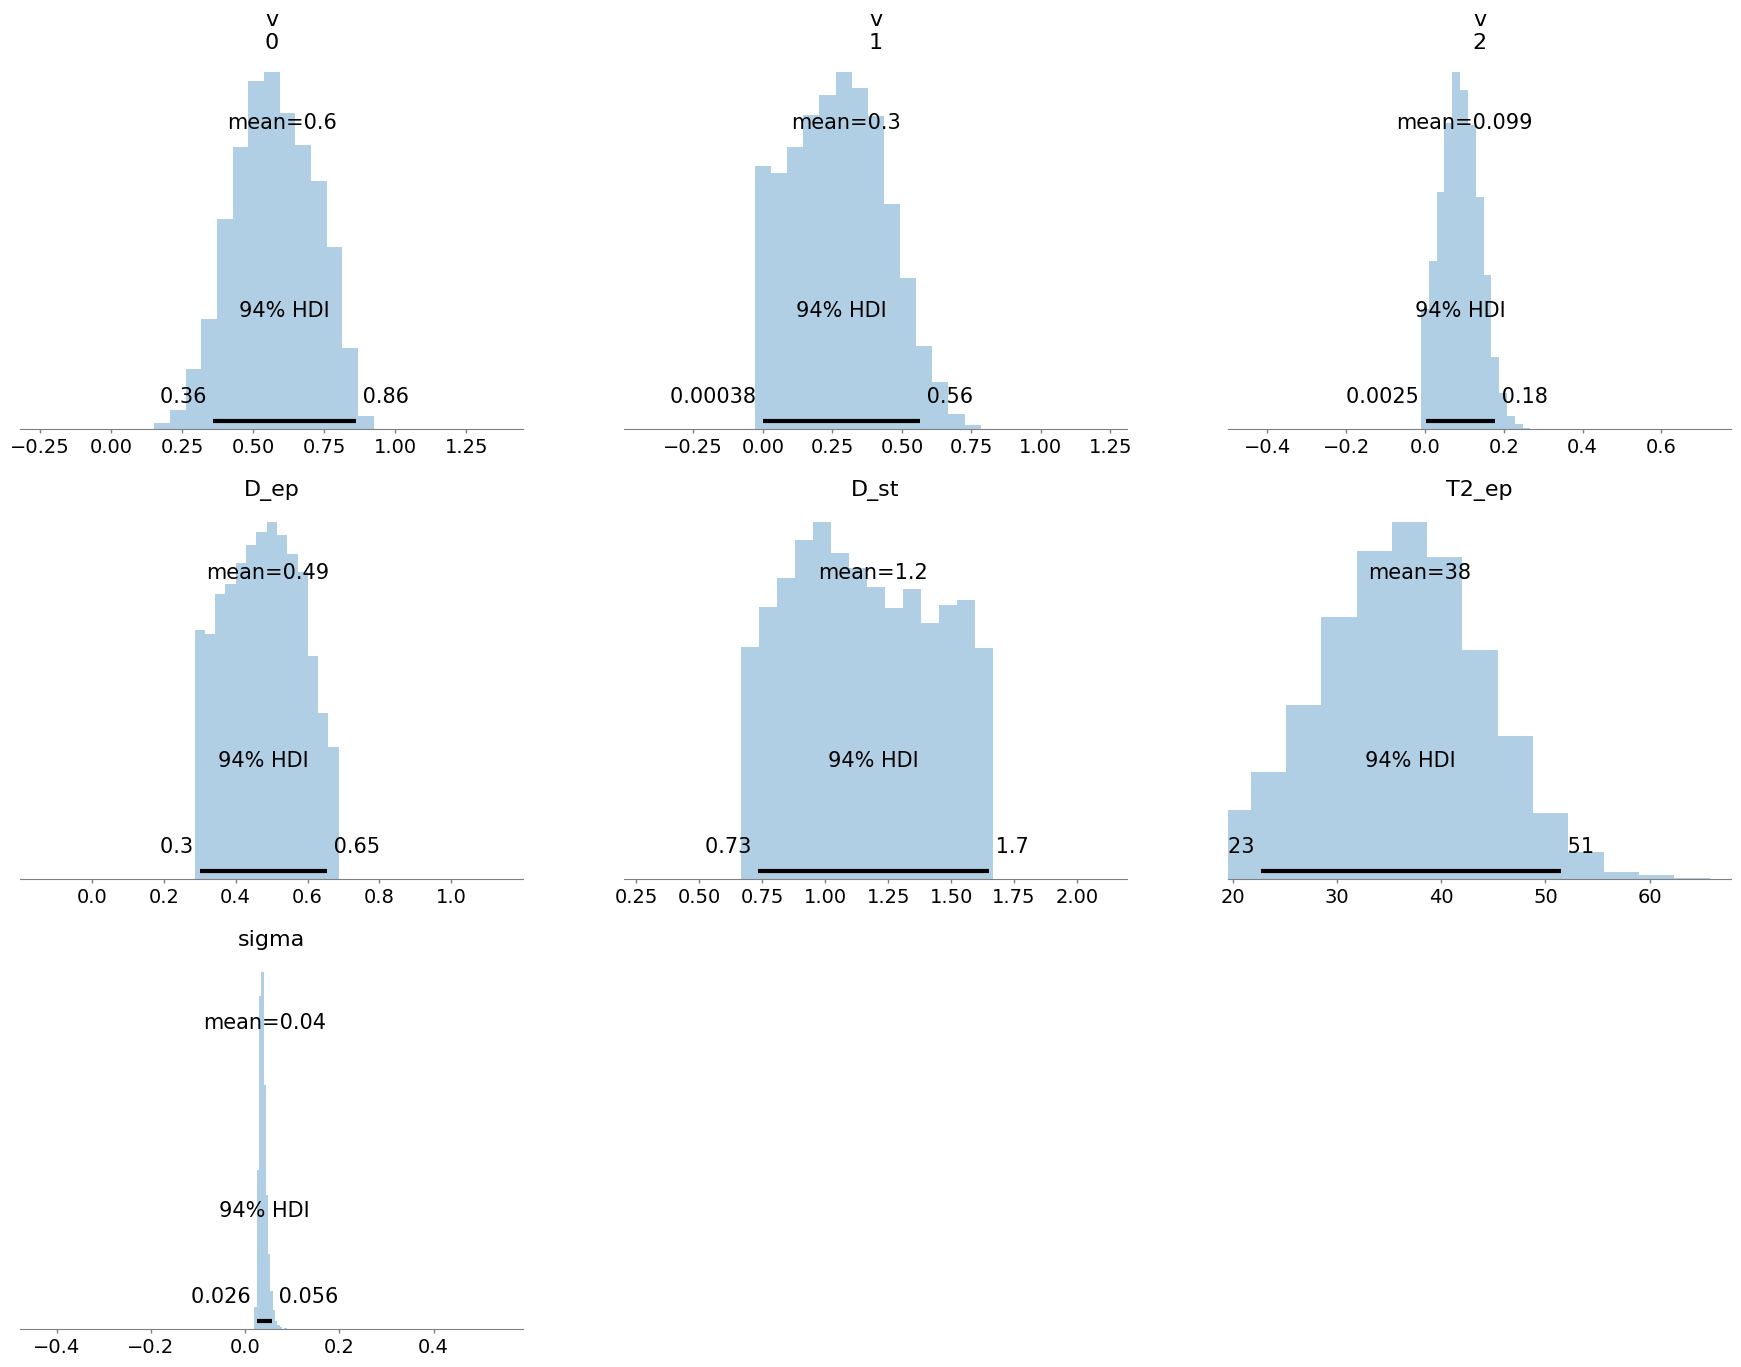

In [16]:
az.plot_posterior(
    trace,
    var_names=["v", "D_ep", "D_st", "T2_ep", "sigma"],
    kind="hist"
);

I reconstructed a three-compartment MRI signal model into a fully Bayesian framework using PyMC and the NUTS sampler. All biologically meaningful constraints were encoded using prior distributions: tissue volume fractions (v_ep, v_st, v_lu) were assigned a Dirichlet(1,1,1) prior distribution, while the diffusion coefficients and T2 values ​​of the epithelium and stroma were assigned uniform prior distributions constrained to their physiologically reasonable ranges. The noise variance, which had to remain non-negative and was known to vary with the MRI scanner, was assigned a HalfNormal prior distribution. The forward model computed the predicted signal S(b,t) for each of the 16 MRI measurements and used a Rice distribution to specify the likelihood function, which more accurately reflects the statistical properties of amplitude MRI data.

Posterior inference showed that the model successfully recovered coherent and biologically meaningful parameter estimates. The posterior mean of epithelial diffusivity D_ep is approximately 0.49, within its acceptable range, with a relatively narrow 94% confidence interval (HDI) of [0.3586, 0.8607]. The posterior mean of mesenchymal diffusivity D_st is approximately 1.19, also within its acceptable range. The posterior mean center of the epithelial T2 parameter is approximately 37.9 ms, with an HDI of [22.7, 51.5], a moderate range, indicating significant uncertainty in this dimension—consistent with the limited number of measurements and the nonlinear structure of the model.

For volume fractions, posterior results suggest that pixels are most likely composed of epithelium (v_ep ≈ 0.60) and mesenchyme (v_st ≈ 0.30), while the luminal component (v_lu ≈ 0.10) is much smaller. The HDI intervals for all three components exclude negative or extreme values, indicating that the Dirichlet prior distribution and the model together provide a good constrained estimate of the tissue components. The posterior mean of the noise parameter σ is also low (approximately 0.040), and the HDI intervals are very narrow, suggesting relatively pure observed signals.

Overall, the posterior distribution performs well, with an effective sample size of several thousand and an R-hat value very close to 1, indicating excellent convergence. Compared to deterministic least squares, the Bayesian method provides richer information by quantifying the uncertainty of each parameter and avoiding boundary-driven point estimation.

3. BONUS

The single-point estimates obtained by the least squares method fit the observed MRI signals well, but often push the parameters to the boundaries of the feasible region, indicating that this nonlinear model may have identifiability limitations. In contrast, the Bayesian MCMC method can recover parameter values ​​that are significantly closer to the known true values. Overall, the MCMC method can provide more accurate and robust inferences for this problem, especially when potential noise and parameter correlations are not negligible.